In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Data Preprocessing

## Restore Variables from explore.ipynb

Use IPython's `%store -r` to restore the `df` dataframe and `continuous_vars` list that were stored at the end of `explore.ipynb`.

**Important**: Make sure you've run `explore.ipynb` first (at least up to the `%store` cells at the end) before running this notebook.

In [2]:
# Restore variables from explore.ipynb (suppress warnings)
import warnings
warnings.filterwarnings('ignore')

%store -r df
%store -r continuous_vars

# Verify they loaded
if 'df' not in locals():
    raise RuntimeError("df was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")
if 'continuous_vars' not in locals():
    raise RuntimeError("continuous_vars was not restored. Make sure you've run explore.ipynb and executed the %store cells at the end.")

In [3]:
# Verify the variables were restored successfully
print(f"DataFrame shape: {df.shape}")
print(f"Continuous variables ({len(continuous_vars)}): {continuous_vars[:5]}...")  # show first 5
df.head(3)

DataFrame shape: (849999, 31)
Continuous variables (19): ['tenure_months', 'salary', 'performance_score', 'satisfaction_score', 'workload_score']...


,employee_id,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,...,goal_achievement_rate,stress_level,burnout_risk,left_company,turnover_reason,risk_factors_summary,turnover_probability_generated,persona_name,role_complexity_score,career_progression_score
0,SYN_00000000,Anonymous Employee,Mid,Research & Development,169,79704.579059,0.632482,0.623746,0.758117,0.662335,...,0.632482,0.908992,0.866643,False,Not Applicable,Severe Burnout Risk,0.290979,ChangeResistor,0.2,1.000000
1,SYN_00000001,Customer Success Manager,Manager,Research & Development,54,29694.288831,0.538587,0.982556,0.788416,0.934661,...,0.538587,0.363321,0.218996,False,Not Applicable,Low Risk,0.156002,NewEnthusiast,0.2,1.000000
2,SYN_00000002,Administrative Assistant,Entry,HR,1,62208.470185,0.624656,0.767200,0.697617,0.888559,...,0.624656,0.664378,0.541531,True,Personal / Relocation,Low Risk,0.233897,NewEnthusiast,0.2,0.836495


## Encoding and Feature Engineering

In [4]:
# One-hot encoding categorical features
categorical_vars = ['role', 'job_level', 'department', 'persona_name', 'communication_patterns']
continuous_vars.remove('turnover_probability_generated')

# continuous vars to be scaled after train-test split
df_staged = df[continuous_vars + categorical_vars]

df_encoded = pd.get_dummies(df_staged, columns=categorical_vars, drop_first=True)
print('df_encoded shape:', df_encoded.shape)


# Skills Count - simple encoding encoding does not change if applyed on all
df_encoded['soft_skills_count'] = df['soft_skills'].apply(len)
df_encoded['technical_skills_count'] = df['technical_skills'].apply(len)



# to be encoded after train-test split
df_encoded['recent_feedback'] = df['recent_feedback']

# add target
df_encoded['left_company'] = df['left_company']

# df_encoded = df_encoded.drop(columns=['turnover_probability_generated'])

for c in df_encoded.columns:
    print(c)


df_encoded shape: (849999, 376)
tenure_months
salary
performance_score
satisfaction_score
workload_score
team_sentiment
project_completion_rate
overtime_hours
training_participation
collaboration_score
email_sentiment
slack_activity
meeting_participation
goal_achievement_rate
stress_level
burnout_risk
role_complexity_score
career_progression_score
role_ Account Executive
role_ Account Manager
role_ Accountant
role_ Actuarial Analyst
role_ Administrative
role_ Administrative Assistant
role_ Administrator
role_ Advisor
role_ Advisory Associate
role_ Advisory Manager
role_ Advisory Software Engineer
role_ Analyst
role_ Anonymous
role_ Apple At Home Advisor
role_ Apple Genius
role_ Applications Developer
role_ Applications Engineer
role_ Architect
role_ Assistant
role_ Assistant Manager
role_ Assistant Store Manager
role_ Assistant Vice President
role_ Associate
role_ Associate Analyst
role_ Associate Consultant
role_ Associate Director
role_ Associate Partner
role_ Associate Software Engi

Preserve test data before fitting and transforming the  scalers, PCA and Clustering 

In [5]:

X = df_encoded.drop(columns=['left_company'])
y = df_encoded['left_company']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (679999, 379)
X_test Shape: (170000, 379)
y_train Shape: (679999,)
y_test Shape: (170000,)


In [6]:
# scale numerics
scaler = MinMaxScaler()

X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])


## Extract from feedback columns

Using the sklearn Tfid Vectorizer allows for extraction of a given number of desired features. 
EXPLAIN MORE

In [7]:

vectorizer = TfidfVectorizer(
    max_features=200,  # dimension limit
    min_df=5,          # Ignore rare terms
    max_df=0.95,        # Ignore too-common terms
    ngram_range=(1,2),
    stop_words='english'
)
X_train_tfidf = vectorizer.fit_transform(X_train['recent_feedback'])
X_test_tfidf = vectorizer.transform(X_test['recent_feedback'])



## Apply PCA and Clustering 

In the originial dataset, the `role` varible 300+ distinct roles. When using the one hot encoding method the dimensionality exploded. To address this we used PCA to reduce the dimensions and settled on keeping enough principle components to keep 90% of the explaind variance of the column. 

In [8]:

role_columns = [col for col in X_train.columns if col.startswith('role_')]

persona_columns = [col for col in X_train.columns if col.startswith('persona_name_')]

com_columns = [col for col in X_train.columns if col.startswith('communication_patterns')]

# features for PCA
train_role_features = X_train[role_columns]
test_role_features = X_test[role_columns]

train_persona_features = X_train[persona_columns]
test_persona_features = X_test[persona_columns]

train_com_features = X_train[com_columns]
test_com_features = X_test[com_columns]

X_train_tfid_dense = X_train_tfidf.toarray()
X_test_tfid_dense = X_test_tfidf.toarray()

# not for PCA
other_features = X_train.drop(columns=role_columns+persona_columns+com_columns+['recent_feedback'])
other_features_test = X_test.drop(columns=role_columns+persona_columns+com_columns+['recent_feedback'])


# Add text features to the PCA 
scaler_tfid = StandardScaler()
scaler_role = StandardScaler()
scaler_persona = StandardScaler()
scaler_com = StandardScaler()

X_tfid_scaled      = scaler_tfid.fit_transform(X_train_tfid_dense)
X_test_tfid_scaled = scaler_tfid.transform(X_test_tfid_dense)

X_role_scaled      = scaler_role.fit_transform(train_role_features.values)
X_test_role_scaled = scaler_role.transform(test_role_features.values)

X_persona_scaled      = scaler_persona.fit_transform(train_persona_features.values)
X_test_persona_scaled = scaler_persona.transform(test_persona_features.values)

X_com_scaled      = scaler_com.fit_transform(train_com_features.values)
X_test_com_scaled = scaler_com.transform(test_com_features.values)


# There a few persona dimensions relative to 'tfid' and 'role', the weight will increase its 
# effect on the componets output from PCA
w = 2.0

X_train_PCA = np.hstack([
    X_tfid_scaled,
    X_role_scaled,
    X_persona_scaled * w,
    X_com_scaled
])

X_test_PCA = np.hstack([
    X_test_tfid_scaled,
    X_test_role_scaled,
    X_test_persona_scaled * w,
    X_test_com_scaled * w
])

# fit PCA for feature reduction 
pca_full = PCA()
pca_full.fit_transform(X_train_PCA)




array([[-1.39974538e+00, -6.45253074e-02, -6.53150979e-01, ...,
        -5.65319299e-16,  3.16798028e-15, -1.44171303e-15],
       [-7.92211164e-01, -1.47358728e-01, -5.64635076e-01, ...,
        -6.26048320e-16,  6.97989572e-16, -1.89086245e-15],
       [-2.61465770e+00,  7.06784129e-01, -3.81394001e+00, ...,
        -8.04910513e-16,  2.45150428e-16,  6.39467590e-16],
       ...,
       [-2.75325130e+00,  7.03845088e-01, -3.98643574e+00, ...,
        -1.19328185e-15, -4.44478908e-15,  5.17130319e-16],
       [ 1.21831172e+00, -1.75498518e+00,  3.19580220e+00, ...,
         1.79709301e-15, -1.37049750e-16, -8.21981424e-16],
       [ 1.50539295e+00, -1.58804134e+00,  2.92397042e+00, ...,
        -1.71810591e-16, -1.75158586e-15, -2.26606872e-15]])

In [9]:
# not for PCA
other_features = X_train.drop(columns=role_columns+persona_columns+com_columns+['recent_feedback'])
other_features_test = X_test.drop(columns=role_columns+persona_columns+com_columns+['recent_feedback'])

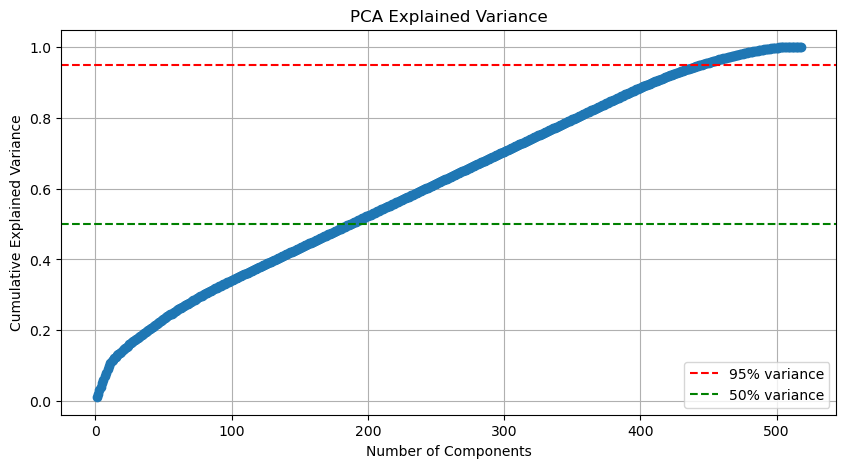

In [10]:

# Plot explained variance to choose number of components
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.50, color='g', linestyle='--', label='50% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [11]:


n_components_50 = np.argmax(cumulative_variance >= 0.50) + 1
# n components to explain 90% of the varence 
n_components = n_components_50 

print(f'Components needed for 50% variance: {n_components_50}')
print(f'Using n_components = {n_components} ')
print(f'Variance explained: {cumulative_variance[n_components-1]:.2%}')


pca = PCA(n_components=n_components)
X_train_pca_50_percent = pca.fit_transform(X_train_PCA)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"confirm varience explained when fit_transform with only {n_components}")
print(f'Variance explained: {cumulative_variance[-1]:.2%}')


Components needed for 50% variance: 188
Using n_components = 188 
Variance explained: 50.16%
confirm varience explained when fit_transform with only 188
Variance explained: 50.16%


In [12]:
X_test_pca_50_percent = pca.transform(X_test_PCA)
X_test_pca_50_percent.shape

(170000, 188)

## Cluster on PCA


### Find the optimal cluster size using silhouette_score

In [13]:
sample_size = 50000 #save some time with random subsampleing
sample_idx = np.random.choice(len(X_train_pca_50_percent), sample_size, replace=False)
X_train_pca_sample = X_train_pca_50_percent[sample_idx]

k_range = range(2,21)
silhouette_scores = []

for k in k_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X_train_pca_sample)
    s = silhouette_score(X_train_pca_sample, labels=labels_tmp)
    silhouette_scores.append(s)
    print(f"k={k}:   Silhouette_score: {s}")

best_k = k_range[np.argmax(silhouette_scores)]


k=2:   Silhouette_score: 0.019406985184891236
k=3:   Silhouette_score: 0.030078217227501144
k=4:   Silhouette_score: 0.04606946861418186
k=5:   Silhouette_score: 0.051464087145581205
k=6:   Silhouette_score: 0.06363131774442189
k=7:   Silhouette_score: 0.0713982220670587
k=8:   Silhouette_score: 0.08083929798726043
k=9:   Silhouette_score: 0.0881377047189376
k=10:   Silhouette_score: 0.07457648899202528
k=11:   Silhouette_score: 0.09529385630625853
k=12:   Silhouette_score: 0.09458155466921135
k=13:   Silhouette_score: 0.0649667483631626
k=14:   Silhouette_score: 0.07466616163138234
k=15:   Silhouette_score: 0.0541419633403927
k=16:   Silhouette_score: 0.05323701559898995
k=17:   Silhouette_score: 0.05961207583303668
k=18:   Silhouette_score: 0.058940631756832666
k=19:   Silhouette_score: 0.05210384729624109
k=20:   Silhouette_score: 0.05778364912220153


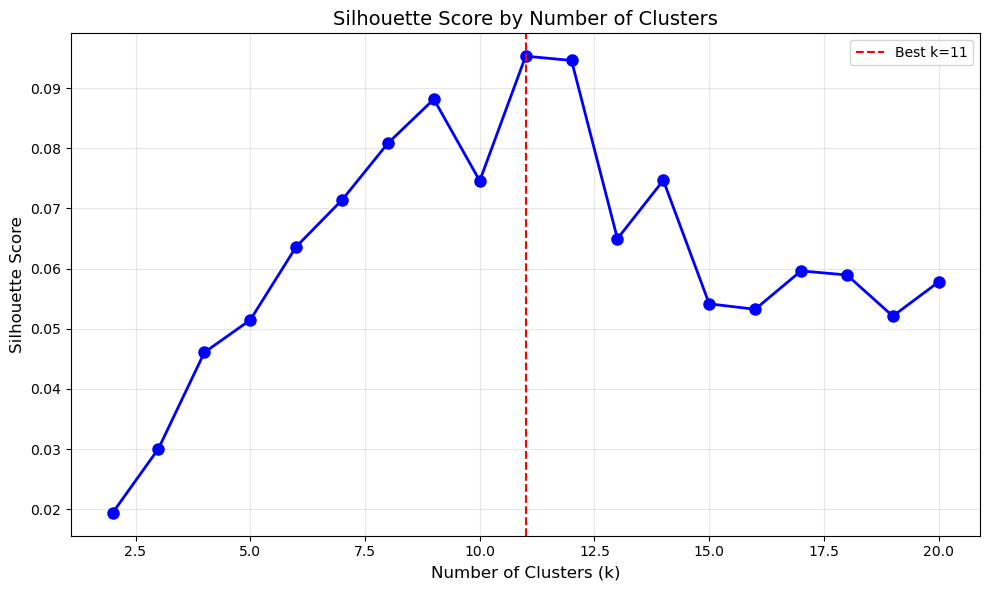

In [14]:
# Visually show the silhouet scores 
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score by Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Fit KMeans with the k=11
no longer use the subsample 

In [15]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_pca_50_percent)
test_clusters = kmeans.predict(X_test_pca_50_percent)

## Encode Cluster results

In [16]:
train_clusters_encoded = pd.get_dummies(train_clusters, prefix='cluster', drop_first=True)
test_clusters_encoded = pd.get_dummies(test_clusters, prefix='cluster', drop_first=True)
test_clusters_encoded = test_clusters_encoded.reindex(columns=train_clusters_encoded.columns, fill_value=0)

#merge with columns not used in PCA
X_train_final = pd.concat([other_features.reset_index(drop=True), train_clusters_encoded.reset_index(drop=True)], axis=1)
print(f'Shape of final X training set: {X_train_final.shape}')
X_test_final = pd.concat([other_features_test.reset_index(drop=True), test_clusters_encoded.reset_index(drop=True)], axis=1)
print(f'Shape of final X test set: {X_test_final.shape}')

Shape of final X training set: (679999, 70)
Shape of final X test set: (170000, 70)


# Train the random forest again!

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

In [18]:
# Model evaluation
def evaluate_model(y_true, y_pred, dataset):
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc = roc_auc_score(y_true, y_pred)
  print(dataset)
  print('Accuracy:', acc)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1-Score:', f1)
  print('ROC-AUC:', roc)

Train Set
Accuracy: 0.5363125534008139
Precision: 0.33992788664583157
Recall: 0.6637477386468476
F1-Score: 0.44960017037053845
ROC-AUC: 0.5745916466713696


Test Set
Accuracy: 0.5233294117647059
Precision: 0.3286016882172552
Recall: 0.6428615606638491
F1-Score: 0.4349014630608516
ROC-AUC: 0.5592348051889146


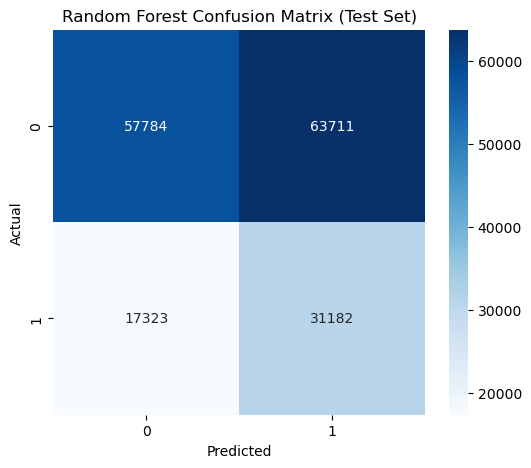

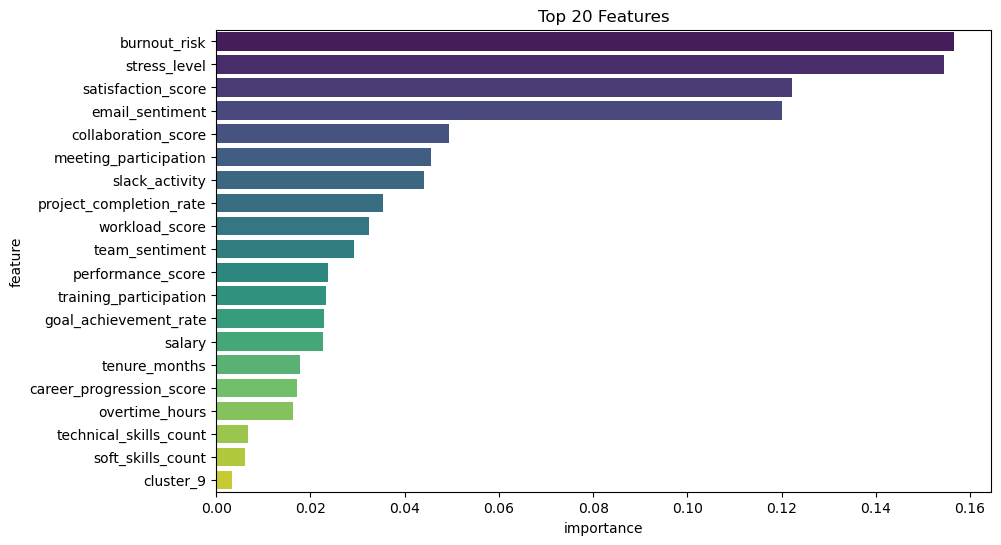

In [19]:
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_final, y_train)

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42,
    bootstrap=True,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Fit model
rf_model.fit(X_train_res, y_train_res)

y_train_pred = rf_model.predict(X_train_final)
y_test_pred = rf_model.predict(X_test_final)

# Evaluate
evaluate_model(y_train, y_train_pred, 'Train Set')
print('\n')
evaluate_model(y_test, y_test_pred, 'Test Set')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances
importances = rf_model.feature_importances_
features = X_train_final.columns
feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='viridis')
plt.title('Top 20 Features')
plt.show()

